13.1 Suppose you are an execution trader. A client calls you with an order to cover a
short position she entered at a price of 100. She gives you two exit conditions:
profit-taking at 90 and stop-loss at 105.

In [1]:
from utils import get_dollar_bars
import pandas as pd
import numpy as np
from itertools import product
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


(a) Assuming the client believes the price follows an O-U process, are these
levels reasonable? For what parameters?  
  
(Forecast:110, holdtime:10)일때 resonalble하다

In [2]:
rule_pt=rule_sl=np.linspace(0, 20, 41)
count=0
forecast_diff=[10, 5, 0, -5, -10]
tau=[5, 10,25, 50, 100]
seed_price=100

def get_trading_sharpe_by_ou_process(params, iter_cnt=1e3, max_hold_period=100, 
                                      seed_price=100, rule_pt=rule_pt, rule_sl=rule_sl):
    phi=2**(-1/params['hold_time'])
    ret=pd.DataFrame(index=rule_pt, columns=rule_sl, 
                     data=np.zeros((len(rule_pt), len(rule_sl))))
    for pt, sl in product(rule_pt, rule_sl):
        temp=[]
        for _ in range(int(iter_cnt)):
            cur_price=seed_price
            for i in range(max_hold_period):
                cur_price=(1-phi)*params['forecast']+phi*cur_price+ np.random.normal(0, params['sigma'])
                price_diff=cur_price-seed_price
                if price_diff >pt or price_diff < -sl or i==max_hold_period-1:
                    temp.append(price_diff)
                    break
        mean_ret=np.mean(temp)
        std_ret=np.std(temp)
        sharpe=(mean_ret/std_ret) if std_ret != 0 else 0
        ret.loc[pt, sl]=sharpe
    return ret

In [ ]:

import matplotlib.pyplot as plt
for prod_ in product(forecast_diff, tau):
    count+=1
    params={'forecast': prod_[0]+seed_price,'hold_time':prod_[1], 'sigma':1}
    output=get_trading_sharpe_by_ou_process(params)
    plt.figure(figsize=(10, 6))
    plt.title(f'Forecast: {params['forecast']} | Hold Time: {params['hold_time']} | Sigma: {params["sigma"]}')
    plt.pcolor(output, cmap='coolwarm', shading='auto')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Stop Loss')
    plt.ylabel('Profit Take')
    plt.xticks(ticks=np.arange(len(rule_sl)), labels=rule_sl)
    plt.yticks(ticks=np.arange(len(rule_pt)), labels=rule_pt)
    plt.grid(False)
    plt.legend()
    plt.savefig(f'sharpe_ratio_{count}.png')
    plt.close()
    print(f'Processed {count} combinations of forecast and tau parameters.')



KeyboardInterrupt: 

(b) Can you think of an alternative stochastic process under which these levels
make sense?

13.2 Fit the timeseries of dollarbars of E-mini S&P500 futures to an O-U process.
Given those parameters:


(a) Produce a heat-map of Sharpe ratios for various profit-taking and stop-loss
levels.

In [3]:
min_df=pd.read_csv("GSPC.INDX_1m.csv", index_col=0, parse_dates=True)
min_df=min_df[min_df.index>="2024-01-01"]
dollar_range=[2**i for i in range(20, 30, 1)]
for dollar in dollar_range:
    dollar_bars=get_dollar_bars(min_df, dollar)
    results=adfuller(dollar_bars['Close'])
    if results[1] < 0.05:
        print(f"Dollar bar size {dollar} is stationary with p-value {results[1]}")
        break

KeyboardInterrupt: 

Estimated OU parameters: {'mean': np.float64(5641.57800639247), 'phi': np.float64(0.9990923072933735), 'sigma': np.float64(10.632730380621398)}


/var/folders/4t/tqsscz0s6wn8sp8kh0264n680000gn/T/ipykernel_94533/2598922260.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


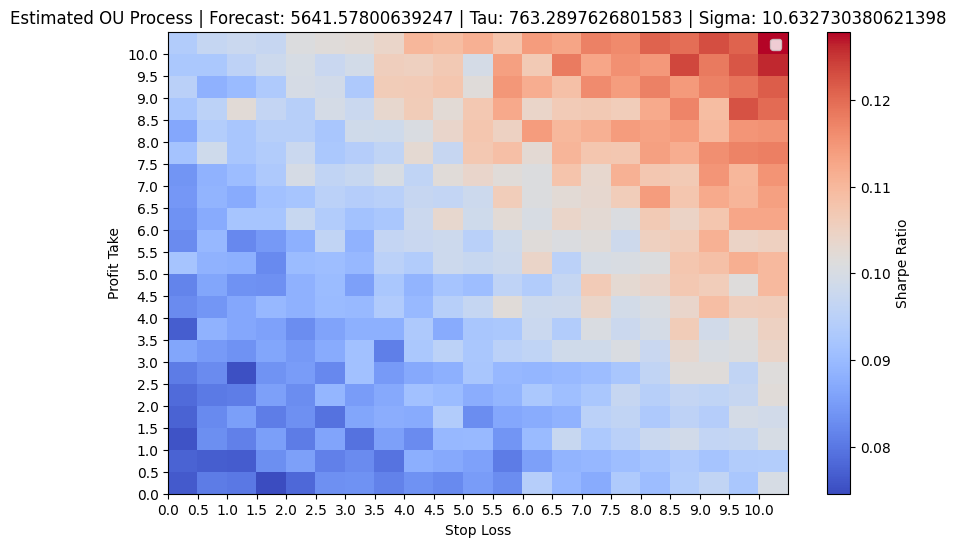

: 

: 

: 

In [ ]:
def get_ou_params(close:pd.Series):
    Y=close[1:].values
    X=close[:-1].values
    X=sm.add_constant(X)
    model=sm.OLS(Y, X).fit()

    alpha, phi=model.params
    residual_std=model.resid.std()
    return {'mean':alpha/(1-phi), 'phi': phi, 'sigma': residual_std}

ou_params=get_ou_params(dollar_bars['Close'])
seed_price=dollar_bars['Close'].iloc[0]
print(f"Estimated OU parameters: {ou_params}")

tau=-1/(np.log2(ou_params['phi']))
params={'forecast':ou_params['mean'], 'hold_time':tau, 'sigma':ou_params['sigma']}

rule_pt=rule_sl=np.linspace(0, 10, 21)
output=get_trading_sharpe_by_ou_process(params, iter_cnt=1e5, max_hold_period=100, 
                                          seed_price=seed_price, rule_pt=rule_pt, rule_sl=rule_sl)
plt.figure(figsize=(10, 6))
plt.title(f'Estimated OU Process | Forecast: {params["forecast"]} | Tau: {params["hold_time"]} | Sigma: {params["sigma"]}')
plt.pcolor(output, cmap='coolwarm', shading='auto')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Stop Loss')
plt.ylabel('Profit Take')
plt.xticks(ticks=np.arange(len(rule_sl)), labels=rule_sl)
plt.yticks(ticks=np.arange(len(rule_pt)), labels=rule_pt)
plt.grid(False)
plt.legend()
plt.show()



(b) What is the OTR?

손절이나 익절 폭을 매우 크게 두고 들고 있는것이 가장 나은 trading 방법이다.

13.3 Repeat exercise 2, this time on a timeseries of dollar bars of   
(a) 10-year U.S. Treasure Notes futures

In [ ]:
import yfinance as yf
from curl_cffi import requests as req

session=req.Session(impersonate="chrome")

treasure=yf.Ticker("ZN=F", session=session)
treasure_data=treasure.history(period="max", interval="1m")

: 

In [ ]:
from statsmodels.tsa.stattools import adfuller
dollar_m=100000
dollar_range=[2**i for i in range(15, 30, 1)]
for dollar in dollar_range:
    treasure_dollar_bars=get_dollar_bars(treasure_data, dollar)
    results=adfuller(treasure_dollar_bars['Close'])
    print('p-value:', results[1])
    if results[1]<0.05:
        print(f"Series is stationary for dollar={dollar}")
        break

p-value: 0.43185381431766773
p-value: 0.399061503900091
p-value: 0.4556510603787791
p-value: 0.44348719798903485
p-value: 0.48634667853988006
p-value: 0.48289945770601894
p-value: 0.4755726758579894
p-value: 0.45998412261701666
p-value: 0.46688041008417064
p-value: 0.42416844027042505
p-value: 0.4675875925618787
p-value: 8.435743262666328e-16
Series is stationary for dollar=67108864


: 

In [9]:
def get_ou_params(close:pd.Series):
    Y=close[1:].values
    X=close[:-1].values
    X=sm.add_constant(X)
    model=sm.OLS(Y, X).fit()

    alpha, phi=model.params
    residual_std=model.resid.std()
    return {'mean':alpha/(1-phi), 'phi': phi, 'sigma': residual_std}

ou_params=get_ou_params(treasure_dollar_bars['Close'])
seed_price=treasure_dollar_bars['Close'].iloc[0]
print(f"Estimated OU parameters: {ou_params}")

tau=-1/(np.log2(ou_params['phi']))
params={'forecast':ou_params['mean'], 'hold_time':tau, 'sigma':ou_params['sigma']}

rule_pt=rule_sl=np.linspace(0, 10, 21)
output=get_trading_sharpe_by_ou_process(params, iter_cnt=1e5, max_hold_period=100, 
                                          seed_price=seed_price, rule_pt=rule_pt, rule_sl=rule_sl)
plt.figure(figsize=(10, 6))
plt.title(f'Estimated OU Process | Forecast: {params["forecast"]} | Tau: {params["hold_time"]} | Sigma: {params["sigma"]}')
plt.pcolor(output, cmap='coolwarm', shading='auto')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Stop Loss')
plt.ylabel('Profit Take')
plt.xticks(ticks=np.arange(len(rule_sl)), labels=rule_sl)
plt.yticks(ticks=np.arange(len(rule_pt)), labels=rule_pt)
plt.grid(False)
plt.legend()
plt.show()

Estimated OU parameters: {'mean': np.float64(109.90323810556949), 'phi': np.float64(0.8335994971203355), 'sigma': np.float64(0.13751477658174885)}


NameError: name 'get_trading_sharpe_by_ou_process' is not defined

(b) WTI Crude Oil futures

In [ ]:
wti=yf.Ticker("CL=F", session=session)
wti_data=wti.history(period="max", interval="1m")
dollar_range=[2**i for i in range(15, 30, 1)]
for dollar in dollar_range:
    wti_dollar_bars=get_dollar_bars(wti_data, dollar)
    results=adfuller(wti_dollar_bars['Close'])
    print('p-value:', results[1])
    if results[1]<0.05:
        print(f"Series is stationary for dollar={dollar}")
        break

: 

: 

In [ ]:
ou_params=get_ou_params(wti_dollar_bars['Close'])
seed_price=wti_dollar_bars['Close'].iloc[0]
print(f"Estimated OU parameters: {ou_params}")

tau=-1/(np.log2(ou_params['phi']))
params={'forecast':ou_params['mean'], 'hold_time':tau, 'sigma':ou_params['sigma']}

rule_pt=rule_sl=np.linspace(0, 10, 21)
output=get_trading_sharpe_by_ou_process(params, iter_cnt=1e5, max_hold_period=100, 
                                          seed_price=seed_price, rule_pt=rule_pt, rule_sl=rule_sl)
plt.figure(figsize=(10, 6))
plt.title(f'Estimated OU Process | Forecast: {params["forecast"]} | Tau: {params["hold_time"]} | Sigma: {params["sigma"]}')
plt.pcolor(output, cmap='coolwarm', shading='auto')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Stop Loss')
plt.ylabel('Profit Take')
plt.xticks(ticks=np.arange(len(rule_sl)), labels=rule_sl)
plt.yticks(ticks=np.arange(len(rule_pt)), labels=rule_pt)
plt.grid(False)
plt.legend()
plt.show()

: 

(c) Are the results significantly different? Does this justify having execution
traders specialized by product?